# LSTM Stock Predictor Using Fear and Greed Index

## Data Preparation

In [147]:
import numpy as np
import pandas as pd
import hvplot.pandas
from numpy.random import seed
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler

In [148]:
# Set the random seed for reproducibility
seed(1)
random.set_seed(2)

In [149]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [150]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [151]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [152]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [153]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [154]:
# Predict Closing Prices using a 10 day window of previous fng values
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [155]:
# Set aside 70% of the data for training and leave the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [156]:
# Scale data between 0 and 1 with MinMaxScaler

# Create a MinMaxScaler variable
scaler = MinMaxScaler()

# Fit the MinMaxScaler variable with the features data X
scaler.fit(X_train)

# Scale the features within the training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler variable with the target data Y
scaler.fit(y_train)

# Finally, the target training and testing sets can be scaled
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [157]:
# Reshape the model features for X_train and X_test
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# After reshaping the X_train and X_test datasets, print out some sample values
print (f"Sample values for X_train:\n{X_train} \n")
print (f"Sample values for X_test:\n{X_test}")

Sample values for X_train:
[[[0.33333333]
  [0.10606061]
  [0.48484848]
  ...
  [0.32307692]
  [0.53846154]
  [0.69230769]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]
  ...
  [0.53846154]
  [0.69230769]
  [0.33846154]]

 [[0.48484848]
  [0.24242424]
  [0.04545455]
  ...
  [0.69230769]
  [0.33846154]
  [0.50769231]]

 ...

 [[0.15151515]
  [0.43939394]
  [0.51515152]
  ...
  [0.6       ]
  [0.52307692]
  [0.52307692]]

 [[0.43939394]
  [0.51515152]
  [0.48484848]
  ...
  [0.52307692]
  [0.52307692]
  [0.49230769]]

 [[0.51515152]
  [0.48484848]
  [0.57575758]
  ...
  [0.52307692]
  [0.49230769]
  [0.44615385]]] 

Sample values for X_test:
[[[0.48484848]
  [0.57575758]
  [0.45454545]
  ...
  [0.49230769]
  [0.44615385]
  [0.83076923]]

 [[0.57575758]
  [0.45454545]
  [0.60606061]
  ...
  [0.44615385]
  [0.83076923]
  [0.86153846]]

 [[0.45454545]
  [0.60606061]
  [0.60606061]
  ...
  [0.83076923]
  [0.86153846]
  [0.76923077]]

 ...

 [[0.39393939]
  [0.16666667]
  [0.48484848]
  ...


---

## Build and Train the LSTM RNN

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [159]:
# Define the LSTM RNN model
model = Sequential()

number_units = 10  # The number of units indicates the size of the time window in each LSTM layer. In this case, our number_units = 10 since we are using a 10-day time window to predict the 11th day closing price.
dropout_fraction = 0.2 # The dropout fraction is set to 0.2, which means that 20% of the neurons will be randomly removed on each epoch.

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True, # With return_sequence set to "True" we will get the results for all hidden states of all the time steps.
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction)) # In order to prevent overfitting of our model, 20% of the units will be dropped on each epoch.
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [160]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [161]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 10)            480       
                                                                 
 dropout_18 (Dropout)        (None, 10, 10)            0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 10)            840       
                                                                 
 dropout_19 (Dropout)        (None, 10, 10)            0         
                                                                 
 lstm_20 (LSTM)              (None, 10)                840       
                                                                 
 dropout_20 (Dropout)        (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [162]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=32, verbose=1)

Epoch 1/10
12/12 [==============================] - 7s 19ms/step - loss: 0.1966
Epoch 2/10
12/12 [==============================] - 0s 18ms/step - loss: 0.1266
Epoch 3/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0823
Epoch 4/10
12/12 [==============================] - 0s 17ms/step - loss: 0.0607
Epoch 5/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0576
Epoch 6/10
12/12 [==============================] - 0s 18ms/step - loss: 0.0582
Epoch 7/10
12/12 [==============================] - 0s 18ms/step - loss: 0.0543
Epoch 8/10
12/12 [==============================] - 0s 23ms/step - loss: 0.0587
Epoch 9/10
12/12 [==============================] - 0s 33ms/step - loss: 0.0547
Epoch 10/10
12/12 [==============================] - 0s 19ms/step - loss: 0.0562


---

## Model Performance

In [142]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.09599962085485458

In [143]:
# Make some predictions
predicted = model.predict(X_test)

In [144]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [145]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,6885.113281
2019-02-21,3974.050049,6931.012207
2019-02-22,3937.040039,6958.496094
2019-02-23,3983.530029,7046.171387
2019-02-24,4149.089844,7087.179688


<AxesSubplot:title={'center':'Actual Vs. Predicted Bitcoin Values'}>

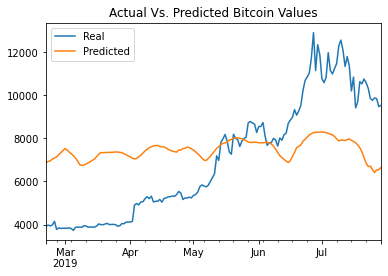

In [163]:
# Plot the real vs predicted values as a line chart
stocks.plot(title="Actual Vs. Predicted Bitcoin Values")